# 02 - Discrimination Analysis

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [3]:
import sys
sys.path.append('../')

import src

In [4]:
plt.style.use('fivethirtyeight')

## Load raw data

In [5]:
df = pd.read_pickle('../data/training.pickle')

In [6]:
df = df.rename(columns={'sex': 'gender', 'ethnicity_officer': 'ethnicity'})
df.stripped = df.stripped.astype('boolean')

## Discrimination Analysis

In order to analyse if search practices are discriminating, we need to define the dimensions in which discrimination is possible and the respective outcomes.
We consider discrimination in one of the following dimensions:
- ethnicity (defined by the officer)
- gender

We define the outcome of a searche as any breach of law that leads to a consequence.
Additionally, we consider if any data dimension is predictive of excessive removal of clothing.

### Do success rates differ among populations

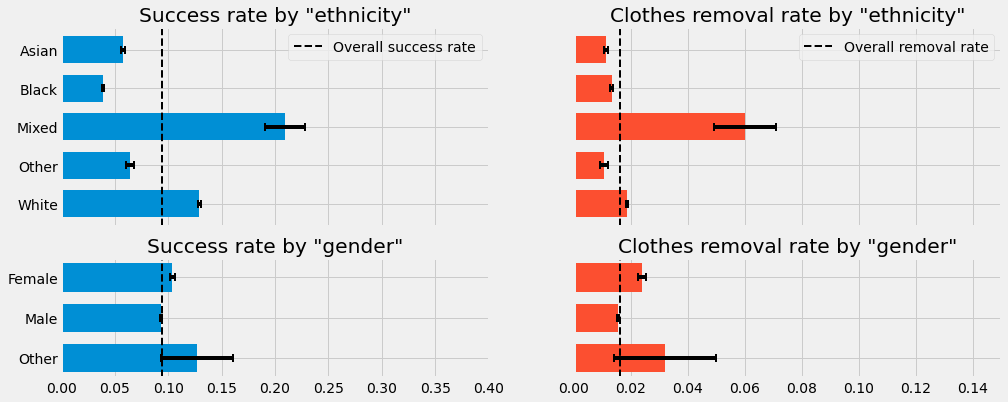

In [9]:
src.plots.make_barplot_success(df, ['ethnicity', 'gender'])

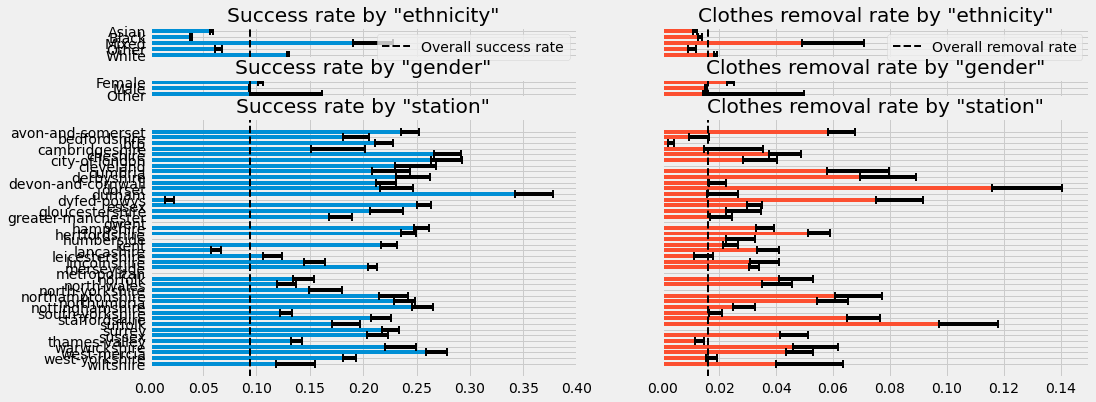

In [8]:
src.plots.make_barplot_success(df, ['ethnicity', 'gender', 'station'])

### Station granularity

In [10]:
# calculate ('station', 'ethnicity', 'gender') subgroup means and averages
df_stations = df.groupby(['station', 'ethnicity', 'gender'])[['success', 'stripped']].agg(['mean', 'std', 'count'])
df_stations = df_stations[(df_stations[('success', 'count')]>30) & df_stations.index.get_level_values('gender').isin(['Female', 'Male'])]
df_stations[('success', 'se')] = df_stations[('success', 'std')]/np.sqrt(df_stations[('success', 'count')])
df_stations[('stripped', 'se')] = df_stations[('stripped', 'std')]/np.sqrt(df_stations[('stripped', 'count')])
df_stations = df_stations.drop(columns=[('success', 'count'), ('stripped', 'count'), ('success', 'std'), ('stripped', 'std')])
df_stations.head(2)

success  stripped   success  stripped
                                        mean      mean        se        se
station           ethnicity gender                                        
avon-and-somerset Asian     Male    0.265455  0.076364  0.026677  0.016044
                  Black     Female  0.142857  0.083333  0.038409  0.030337

In [11]:
# add 'station' means
df_station_means = df.groupby('station')[['success', 'stripped']].mean()
df_station_means.columns = pd.MultiIndex.from_product([['station_means'], df_station_means.columns])

# format dataframe
df_merged = df_stations.merge(df_station_means, left_on=df_stations.index.get_level_values('station'), right_on=df_station_means.index)
df_merged.index = df_stations.index
df_merged = df_merged.drop(columns=[('key_0',)])

# calcualte z-scores
df_merged[('success', 'z')] = (df_merged[('success', 'mean')] - df_merged[('station_means', 'success')]) / df_merged[('success', 'se')]
df_merged[('stripped', 'z')] = (df_merged[('stripped', 'mean')] - df_merged[('station_means', 'stripped')]) / df_merged[('stripped', 'se')]

df_merged.head(2)

/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


success  stripped   success  stripped  \
                                        mean      mean        se        se   
station           ethnicity gender                                           
avon-and-somerset Asian     Male    0.265455  0.076364  0.026677  0.016044   
                  Black     Female  0.142857  0.083333  0.038409  0.030337   

                                   station_means             success  stripped  
                                         success  stripped         z         z  
station           ethnicity gender                                              
avon-and-somerset Asian     Male        0.244034  0.063005  0.802976  0.832583  
                  Black     Female      0.244034  0.063005 -2.634162  0.670062

In [16]:
df_disc = pd.DataFrame(index=df_merged.index, data={'success': df_merged[('success', 'z')],
                                                    'stripped': df_merged[('stripped', 'z')]})
df_disc = df_disc.replace(-np.inf, np.nan).replace(np.inf, np.nan)
df_disc = df_disc.unstack().unstack()

# transform to p-values
# df_disc = np.sign(df_disc) * sp.stats.norm.cdf(df_disc.abs())
df_missing = df_disc.isna()

# highligt significant groups
df_heat = (df_disc>1.96).astype(int) - (df_disc<-1.96).astype(int)

# invert logic for success rates
df_heat.iloc[:,0:10] *= -1
df_heat[df_missing.values] = np.nan

df_heat.head(2)

success                                                   \
gender               Male                         Female                     
ethnicity           Asian Black Mixed Other White  Asian Black Mixed Other   
station                                                                      
avon-and-somerset     0.0   0.0   0.0  -1.0  -1.0    NaN   1.0   1.0   NaN   
bedfordshire          0.0   0.0   NaN   0.0   0.0    NaN   1.0   NaN   NaN   

                        stripped                                             \
gender                      Male                         Female               
ethnicity         White    Asian Black Mixed Other White  Asian Black Mixed   
station                                                                       
avon-and-somerset   1.0      0.0   1.0   1.0   0.0  -1.0    NaN   0.0   0.0   
bedfordshire        0.0      0.0   0.0   NaN   NaN   0.0    NaN   0.0   NaN   

                               
gender                         
ethnicity         Other White  
station                        
avon-and-somerset   NaN   0.0  
bedfordshire        NaN   0.0

/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


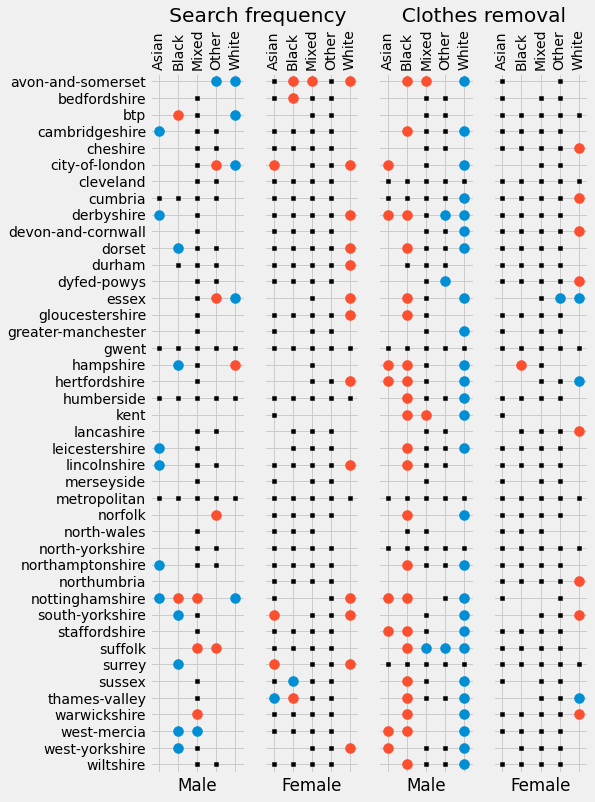

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(7, 12))#, gridspec_kw={'width_ratios': [5, 5, 2, 2, 2, 2, 2]})

for i, ax in enumerate(axes[0:2]):
    data = df_heat.iloc[:, 0+(i*5):5+(i*5)]
    ax.scatter(np.argwhere(data.values == -1)[:,1], 41-np.argwhere(data.values == -1)[:,0], s=100)
    ax.scatter(np.argwhere(data.values == 1)[:,1], 41-np.argwhere(data.values == 1)[:,0], s=100)
    ax.scatter(np.argwhere(data.isna().values)[:,1], 41-np.argwhere(data.isna().values)[:,0], s=10, marker='s', color='k')
    ax.set_xlim([-0.5, 4.5])
    ax.set_ylim([-0.5, 41.5])
    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(data.columns.get_level_values('ethnicity'), rotation=90)
    
    ax.set_xticks(np.arange(0, len(data.columns)))
    ax.set_yticks(np.arange(0, len(data.index)))
    
    if i==0:
        ax.set_yticklabels(data.index[::-1], rotation=0)
        ax.set_title('                   Search frequency')
        ax.set_xlabel('Male')
    else:
        ax.set_yticklabels([])
        ax.set_xlabel('Female')
    
for i, ax in enumerate(axes[2:4]):
    data = df_heat.iloc[:, 10+(i*5):15+(i*5)]
    ax.scatter(np.argwhere(data.values == -1)[:,1], 41-np.argwhere(data.values == -1)[:,0], s=100)
    ax.scatter(np.argwhere(data.values == 1)[:,1], 41-np.argwhere(data.values == 1)[:,0], s=100)
    ax.scatter(np.argwhere(data.isna().values)[:,1], 41-np.argwhere(data.isna().values)[:,0], s=10, marker='s', color='k')
    ax.set_xlim([-0.5, 4.5])
    ax.set_ylim([-0.5, 41.5])
    
    ax.set_xticks(np.arange(0, len(data.columns)))
    ax.set_yticks(np.arange(0, len(data.index)))
    
    if i==0:
        ax.set_title('                  Clothes removal')
        ax.set_xlabel('Male')
    else:
        ax.set_xlabel('Female')
    
    ax.set_yticklabels([])
    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(data.columns.get_level_values('ethnicity'), rotation=90)

plt.show()

/home/rubelrennfix/.virtualenvs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


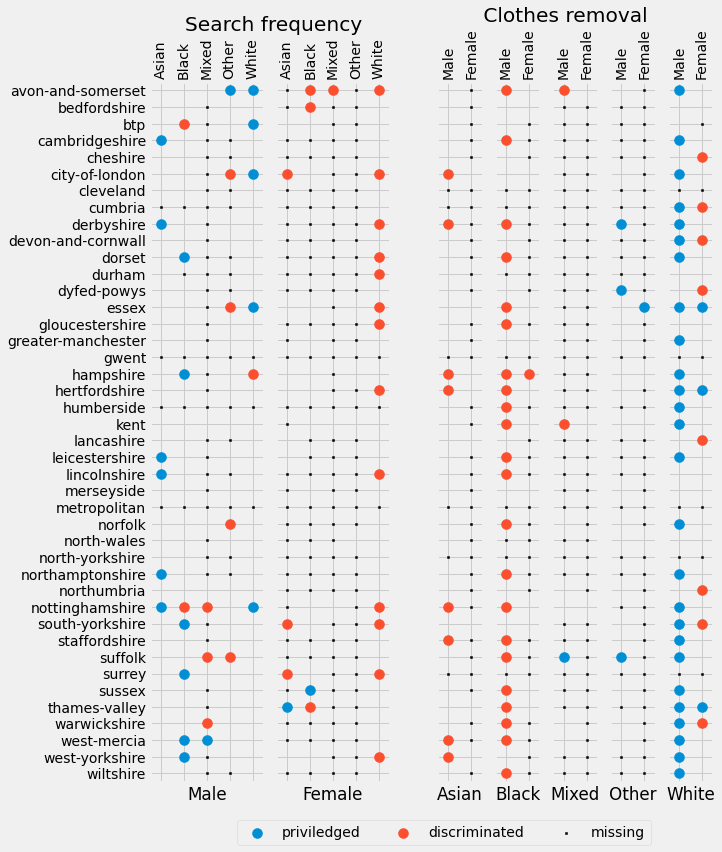

In [28]:
fig, axes = plt.subplots(1, 8, figsize=(9, 12), gridspec_kw={'width_ratios': [5, 5, 1, 2, 2, 2, 2, 2]})

for i, ax in enumerate(axes[0:2]):
    data = df_heat.iloc[:, 0+(i*5):5+(i*5)]
    ax.scatter(np.argwhere(data.values == -1)[:,1], 41-np.argwhere(data.values == -1)[:,0], s=100, label='priviledged')
    ax.scatter(np.argwhere(data.values == 1)[:,1], 41-np.argwhere(data.values == 1)[:,0], s=100, label='discriminated')
    ax.scatter(np.argwhere(data.isna().values)[:,1], 41-np.argwhere(data.isna().values)[:,0], s=8, marker='s', color='k', label='missing')
    ax.set_xlim([-0.5, 4.5])
    ax.set_ylim([-0.5, 41.5])
    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(data.columns.get_level_values('ethnicity'), rotation=90)
    
    ax.set_xticks(np.arange(0, len(data.columns)))
    ax.set_yticks(np.arange(0, len(data.index)))
    
    if i==0:
        ax.set_yticklabels(data.index[::-1], rotation=0)
        ax.set_title('                     Search frequency')
        ax.set_xlabel('Male')
    else:
        ax.set_yticklabels([])
        ax.set_xlabel('Female')
        
    if i==1:
        ax.legend(loc='lower left', bbox_to_anchor=(-0.4, -0.1), ncol=3)
        
ax = axes[2]
ax.grid(False)
ax.set_yticks([])
ax.set_xticks([])
    
for i, ax in enumerate(axes[3:8]):
    data = df_heat.iloc[:, np.array([10, 15])+i]
    ax.scatter(np.argwhere(data.values == -1)[:,1], 41-np.argwhere(data.values == -1)[:,0], s=100, label='priviledged')
    ax.scatter(np.argwhere(data.values == 1)[:,1], 41-np.argwhere(data.values == 1)[:,0], s=100, label='discriminated')
    ax.scatter(np.argwhere(data.isna().values)[:,1], 41-np.argwhere(data.isna().values)[:,0], s=8, marker='s', color='k', label='missing')
    ax.set_xlim([-0.5, 1.5])
    ax.set_ylim([-0.5, 41.5])
    
    ax.set_xticks(np.arange(0, len(data.columns)))
    ax.set_yticks(np.arange(0, len(data.index)))
    
    if i==0:
        ax.set_title('                                 Clothes removal')
    ax.set_xlabel(['Asian', 'Black', 'Mixed', 'Other', 'White'][i])

    ax.set_yticklabels([])
    ax.xaxis.set_ticks_position('top')
    ax.set_xticklabels(data.columns.get_level_values('gender'), rotation=90)    
    
fig.savefig('../reports/figures/discrimination.jpg', dpi=300, bbox_inches='tight')
plt.show()